# Final project: Stock Prediction

Given the recent stock market history, you will predict the return for ticker AAPL for the day ahead.

# Objectives

You will demonstrate your strengths in several areas, especially
- Exploratory Data Analysis
- Feature Engineering
- Creating, testing and evaluating models
- Error analysis
and Prediction **using Neural Networks**.

Your objective will be to predict next period price returns of a stock given its past prices.

**To be precise**
- given recent prices for AAPL you will predict the next *return*
- *return* will be defined precisely below
- you will be evaluated on a holdout data directory
    - it will have 2 years of data
    - you will be required to predict next period returns for the final 200 days
    - when making a prediction for date $t$, where $t$ is in the holdout data range (**beyond** the last training date)
        - you may use *actual* holdout data for dates strictlty prior to date $t$
        - That is: your prediction for date $t$ *does not* need to be dependent on your *prediction* for date $(t-1)$
    

**Predicting forward returns/prices is hard ! If you could do it well: you would be rich**

Given that fact, out of sample performance will **not** be the sole metric for your grade

This project will test your ability to analyze data, create hypotheses, test them, and improve through iteration.

**You will learn a lot, especially from failures**

This project provides a wealth of opportunity for
- Exploratory data analysis
    - This can suggest several different approaches to building one or more models
- Error Analysis
- Creating, and evaluating models iteratively, learning from past failures and successes.

So your performance will be based on your creativity and experimental process, even if the process
does not lead to great out of sample performance

# The data

As explained in the Final Project Overview:
- you will be given a data directory for training
    - supplied as a compressed archive file in the course's Resource tab in NYU Classes
    - unpacking this file will yield directory `./Data/train`

The data directory will contain one file per ticker, with a history going back many years of fields including
- Price: Close, Open, High, Low
- Volume

"return" means the percent change in the **Close** feature

You will need to 
- decide which files and which fields to use
- prepare the data for training and testing
    - convert from price to return as necessary
    - prepare train and test examples:
    

## Data preparation

- The files contain prices; your goal is to predict a *return* not a price
- Your goal is to predict the **percent change of the Close feature** ("return")
- Your predicted return for day $t$ should be a function of data occuring *before* day $t$

So your first step will be to create a suitable training set.

For example, the following training set is a good starting point:
- each row is an example
- each row will have a column `Dt` indicating time $t$
- each example has *at least* 20 features
    - derived from AAPL features occuring *before* time $t$
- the target for the row with time $t$ should be the *return* of AAPL for date $t$
    - i.e., the percent price change of AAPL from time $t-1$ to time $t$



# Out of sample evaluation

*You* should test your models out of sample.

This will be beneficial as *we* will evaluate your model out of sample using a holdout data directory.

The *holdout data directory* will be for dates that are strictly later than the latest date in the
training data directory.
- will contain 2 years of data
- you will be required to predict the latest 200 returns of AAPL for this holdout directory
- your submission *must work on the holdout directory*
    - you should assume the directory is at relative path  `./data/holdout`

So you might want to create your own validation/test data (from the training data directory) that mimics
what the holdout data directory will contain.

It is up to you to decide on the out of sample data that you use for model development.


# Suggestions for  getting started

The problem we presented to you is unstructured and not precisely defined in full detail.

- Start by defining, in detail,  the problem that you will attempt to solve
    - Do you view this as a Regression task ?  A Classification task
    - Justify your choice
~ Define the Performance Metric that you think is appropriate
    - Justify your choice

- Start with a simple model, using only data from AAPL (few features)
    - Use the model to get a feel for the problem
    - Will be a good baseline
    - Will help you form new hypotheses to test
        - may guide the choice of additional features
- Create new models iteratively
    - Train and evaluate a "simpler" model
    - Evalute performance
    - Perform error analysis
    - Propose a new "less simple" model
        - add as many features as you like, from any file in the directory

- Be disciplined in your process: avoid repeating code
    - It will be easier if you have a single piece of code that works for
        - the training directory
        - the test directory (that you might choose to create)
        - the holdout directory
    - This will
        - simplify your process
        - help ensure that your submission will work on the holdout directory !
   

# Warning: Avoid looking into the future !

Obviously, you should not use knowledge of the future to predict future prices.

But it is surprisingly easy to inadvertantly do so !  For example:
- when standardizing a data set: you might compute averages and standard deviations over the full range of dates
    - this means that the earliest dates have implicit knowledge of later dates
        - for example, suppose the mean increases after 10 days
        - the observations of the first 9 days *should not know* that the mean of the entire data range is different than what is available from earlier observations

# Evaluating your model
   
Your goals
- demonstrate that your models can predict in-sample (based on training only) somewhat successfully
    - this is easier than predicting out of sample
    - this will show that your model has "learned" something
- evaluate your model out of sample using the validation/test set you created
- run multiple experiments to try to improve out of sample prediction
- present a "final model" which we will evaluate with a holdout dataset
     - The holdut dataset will be identical in structure to the full data set we provide
     - *BUT* the dates will be strictly after the dates in the full dataset.

# Final reminder: document your thought process

**The key to getting a good grade** is to
- document everything you do
- justify the many choices you will have to make -- use data and intuition to back up your statements
- report on failed theories/experiments
    - it shows the amount of effort you expended
    - tell us
        - why you thought it was a good idea to try
        - what you learned from the failure
        - how the failure led you to try something different
        
The out of sample prediction is hard -- you may or may not do well.

What is important is to see how you tried to improve and how failure as well as success led to
better experiments.

# Get data

In [681]:
import numpy as np
import pandas as pd
import sklearn
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn
from sklearn.impute import SimpleImputer
import os
import copy

data_dir = './Data/train/'
list_data = os.listdir(data_dir)
tick_list = [i.split('.')[0] for i in list_data]
print(tick_list)

['CSCO', 'V', 'ADBE', 'XLE', 'INTC', 'XLF', 'XLP', 'MSFT', 'ACN', 'XLB', 'XLU', 'NVDA', 'XLV', 'FB', 'IBM', 'XLY', 'XLK', 'SPY', 'XLI', 'GOOG', 'XLRE', 'MA', 'AAPL', 'CRM']


The above tickers are contained in the Data file, and we are going to use these series to predict the AAPL

## Create dataframe

In [682]:
target = "AAPL"
target_df = pd.read_csv(data_dir + target + '.csv').set_index("Dt")
target_df["Return"] = target_df["Close"].pct_change(1)
target_df["Adj Return"] = target_df["Adj Close"].pct_change(1)
target_df

,Adj Close,Close,Div,Factor,High,Low,Open,Volume,Return,Adj Return
Dt,,,,,,,,,,
2000-01-03,3.4785,111.938,0.0,1.0,112.5000,101.688,104.8750,133949200.0,NaN,NaN
2000-01-04,3.1852,102.500,0.0,1.0,110.6250,101.188,108.2500,128094400.0,-0.084315,-0.084318
2000-01-05,3.2318,104.000,0.0,1.0,110.5630,103.000,103.7500,194580400.0,0.014634,0.014630
2000-01-06,2.9521,95.000,0.0,1.0,107.0000,95.000,106.1183,191993200.0,-0.086538,-0.086546
2000-01-07,3.0920,99.500,0.0,1.0,101.0000,95.500,96.5000,115183600.0,0.047368,0.047390
...,...,...,...,...,...,...,...,...,...,...
2016-12-23,111.3073,116.520,0.0,1.0,116.5255,115.590,115.5900,14249500.0,0.001978,0.001978
2016-12-27,112.0142,117.260,0.0,1.0,117.8000,116.490,116.5200,18296900.0,0.006351,0.006351
2016-12-28,111.5366,116.760,0.0,1.0,118.0170,116.200,117.5200,20905900.0,-0.004264,-0.004264


In [683]:
all_df = target_df
for each in tick_list:
    if each == target:
        continue
    df = pd.read_csv(data_dir + each + '.csv').set_index("Dt")
    df["Return"] = df["Close"].pct_change(1)
    df["Adj Return"] = df["Adj Close"].pct_change(1)
    all_df = all_df.join(df, how = "left", rsuffix = "_" + str(each))

In [684]:
AAPL_col = [name + "_AAPL" for name in all_df.columns[:11]]
all_df.columns = AAPL_col + list(all_df.columns[11:])
print(f'Data shape:{all_df.shape}')

Data shape:(4277, 240)


In [685]:
all_df["Forward_AAPL"] = all_df[all_df.columns[0]].pct_change(periods=1).shift(-1)
all_df


,Adj Close_AAPL,Close_AAPL,Div_AAPL,Factor_AAPL,High_AAPL,Low_AAPL,Open_AAPL,Volume_AAPL,Return_AAPL,Adj Return_AAPL,...,Close_CRM,Div_CRM,Factor_CRM,High_CRM,Low_CRM,Open_CRM,Volume_CRM,Return_CRM,Adj Return_CRM,Forward_AAPL
Dt,,,,,,,,,,,,,,,,,,,,,
2000-01-03,3.4785,111.938,0.0,1.0,112.5000,101.688,104.8750,133949200.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.084318
2000-01-04,3.1852,102.500,0.0,1.0,110.6250,101.188,108.2500,128094400.0,-0.084315,-0.084318,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.014630
2000-01-05,3.2318,104.000,0.0,1.0,110.5630,103.000,103.7500,194580400.0,0.014634,0.014630,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.086546
2000-01-06,2.9521,95.000,0.0,1.0,107.0000,95.000,106.1183,191993200.0,-0.086538,-0.086546,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.047390
2000-01-07,3.0920,99.500,0.0,1.0,101.0000,95.500,96.5000,115183600.0,0.047368,0.047390,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.017594
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2016-12-23,111.3073,116.520,0.0,1.0,116.5255,115.590,115.5900,14249500.0,0.001978,0.001978,...,69.87,0.0,1.0,70.0100,69.31,69.69,2274000.0,-0.000429,-0.000429,0.006351
2016-12-27,112.0142,117.260,0.0,1.0,117.8000,116.490,116.5200,18296900.0,0.006351,0.006351,...,69.85,0.0,1.0,70.4260,69.64,69.84,2939700.0,-0.000286,-0.000286,-0.004264
2016-12-28,111.5366,116.760,0.0,1.0,118.0170,116.200,117.5200,20905900.0,-0.004264,-0.004264,...,69.09,0.0,1.0,70.0600,68.85,69.85,4313700.0,-0.010880,-0.010880,-0.000257


## Assign Train test data

Since we are working on the time series, the usual way to split training test data are not appropriate here. If we randomly pick train/test sample, the features will be not useful anymore because they are highly correlated with timesamp.

In [686]:
X = all_df.iloc[:,:-1]
Y = all_df["Forward_AAPL"]
split_ratio = 0.8

X_train, X_test = X.iloc[: int(len(X) * split_ratio), :], X.iloc[int(len(X) * split_ratio):-1, :]
y_train, y_test = Y.iloc[: int(len(Y) * split_ratio)], Y.iloc[int(len(Y) * split_ratio):-1]

print("X shape",X.shape)
print("Y shape",Y.shape)
print("X_train",X_train.shape)
print("Y_train",y_train.shape)
print("X_test",X_test.shape)
print("y_test",y_test.shape)


X shape (4277, 240)
Y shape (4277,)
X_train (3421, 240)
Y_train (3421,)
X_test (855, 240)
y_test (855,)


## Data analysis

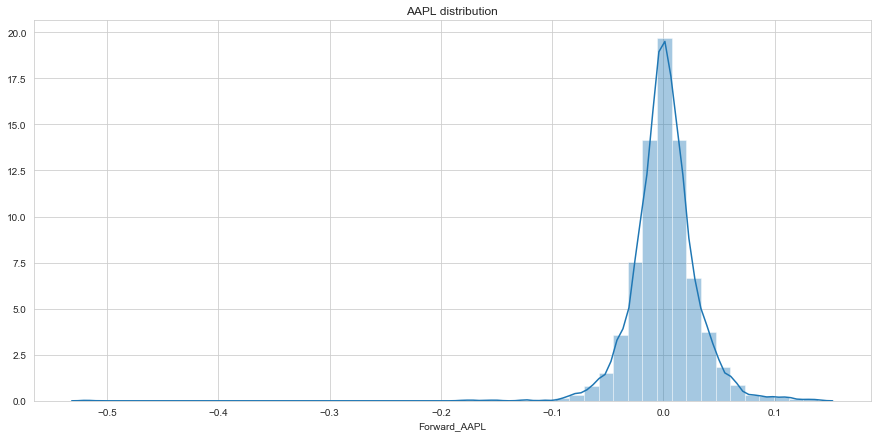

In [687]:
plt.figure(figsize=(15,7))
sns.distplot(y_train)
plt.title("AAPL distribution");

In [688]:
print("Annualized return of AAPL is",round(y_train.mean()*252,4))
print("Annualized volatility of AAPL is",round(y_train.std()*16,4))

Annualized return of AAPL is 0.3187
Annualized volatility of AAPL is 0.4631


Text(0.5, 1.0, 'Prediction power of volatility')

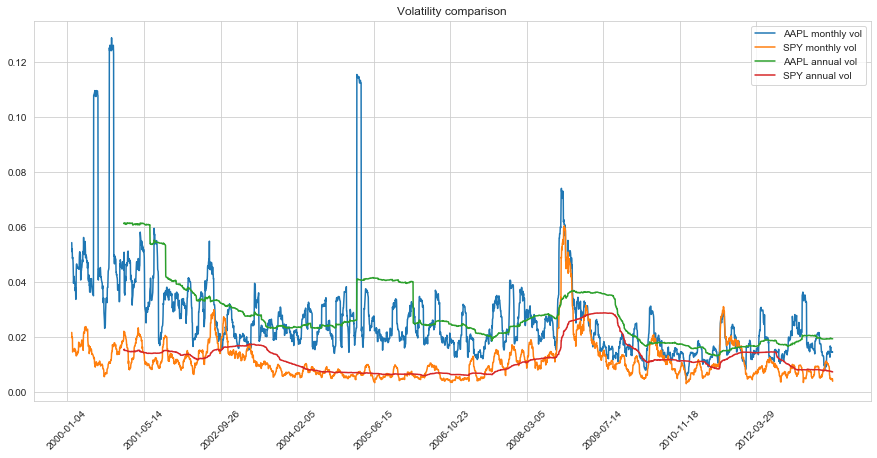

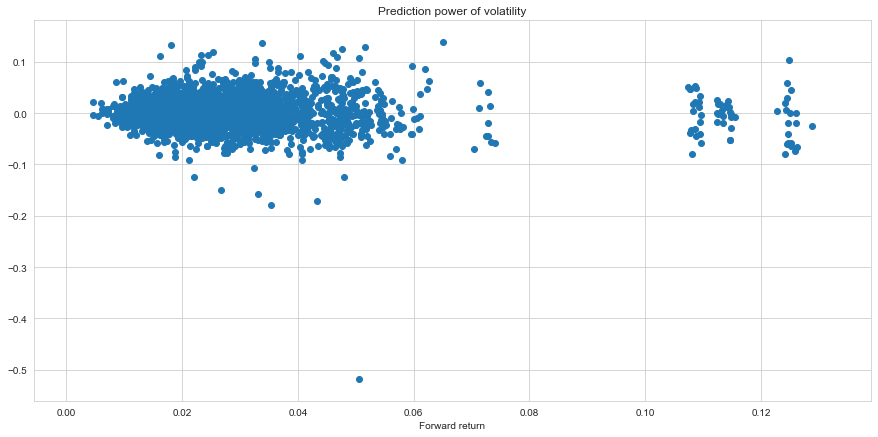

In [689]:
plt.figure(figsize=(15,7))
each = round(len(X_train.index)/10)
plt.xticks(list(range(1,len(X_train.index),each)), list(X_train.index[list(range(1,len(X_train.index),each))].values), rotation = 45)
plt.plot(X_train['Return_AAPL'].rolling(20).std(), label='AAPL monthly vol')
plt.plot(X_train['Return_SPY'].rolling(20).std(), label='SPY monthly vol')
plt.plot(X_train['Return_AAPL'].rolling(252).std(), label='AAPL annual vol')
plt.plot(X_train['Return_SPY'].rolling(252).std(), label='SPY annual vol')
plt.legend()
plt.title('Volatility comparison')

plt.figure(figsize=(15,7))
plt.scatter(X_train['Return_AAPL'].rolling(20).std(), y_train)
plt.xlabel('Montly volatility')
plt.xlabel('Forward return')
plt.title('Prediction power of volatility')

AAPL's volatility is highly positively correlated with SPY's volatility. But AAPL's volatility is higher than SPY's volatility.

As time goes by, the volatility becomes smaller and smaller

For the time period of financial crisis, the trend is significantly different from the normal time

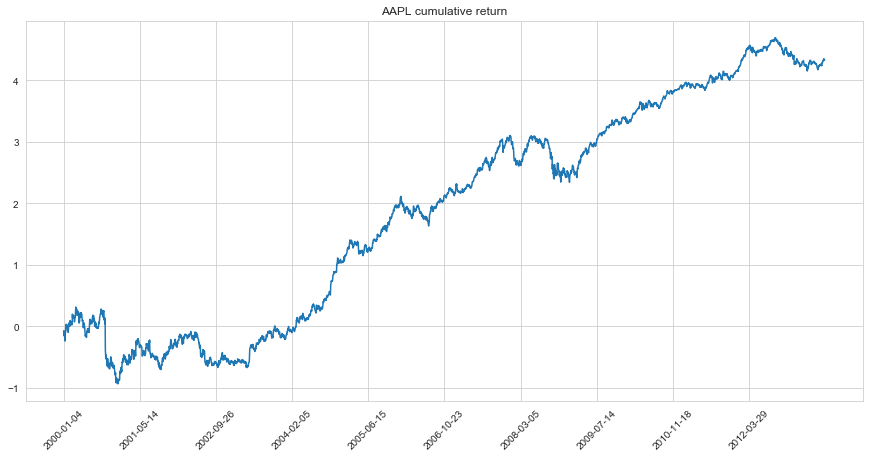

In [690]:
plt.figure(figsize=(15,7))
each = round(len(y_train.index)/10)
plt.xticks(list(range(1,len(y_train.index),each)), list(y_train.index[list(range(1,len(y_train.index),each))].values), rotation = 45)
plt.plot(y_train.cumsum())
plt.title('AAPL cumulative return');




Text(0.5, 1.0, 'AAPL forward return')

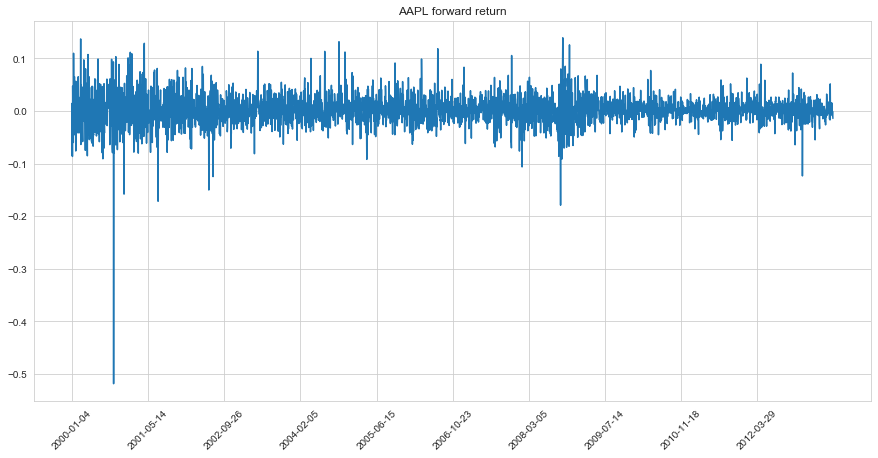

In [691]:
plt.figure(figsize=(15,7))
each = round(len(y_train.index)/10)
plt.xticks(list(range(1,len(y_train.index),each)), list(y_train.index[list(range(1,len(y_train.index),each))].values), rotation = 45)
plt.plot(y_train)
plt.title('AAPL forward return')

Text(0.5, 1.0, 'Trends with moving average')

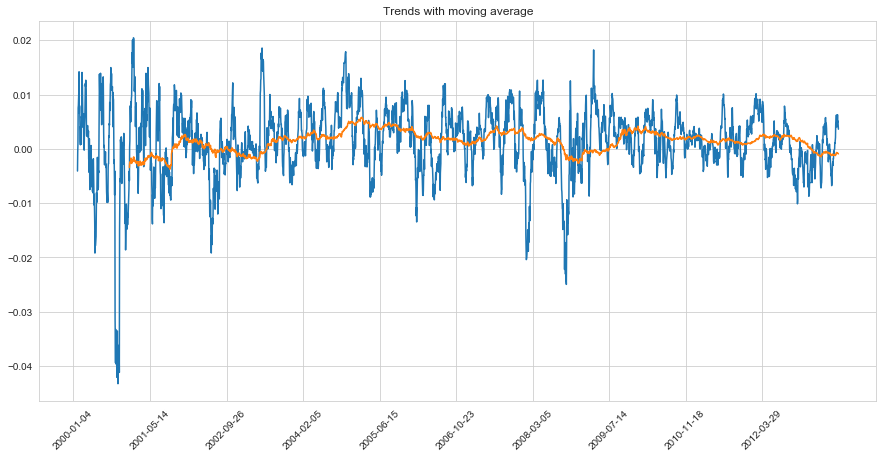

In [692]:
plt.figure(figsize=(15,7))
each = round(len(y_train.index)/10)
plt.xticks(list(range(1,len(y_train.index),each)), list(y_train.index[list(range(1,len(y_train.index),each))].values), rotation = 45)
plt.plot(y_train.rolling(20).mean())
plt.plot(y_train.rolling(252).mean())
plt.title('Trends with moving average')

Text(0.5, 1.0, 'Prediction power of past returns')

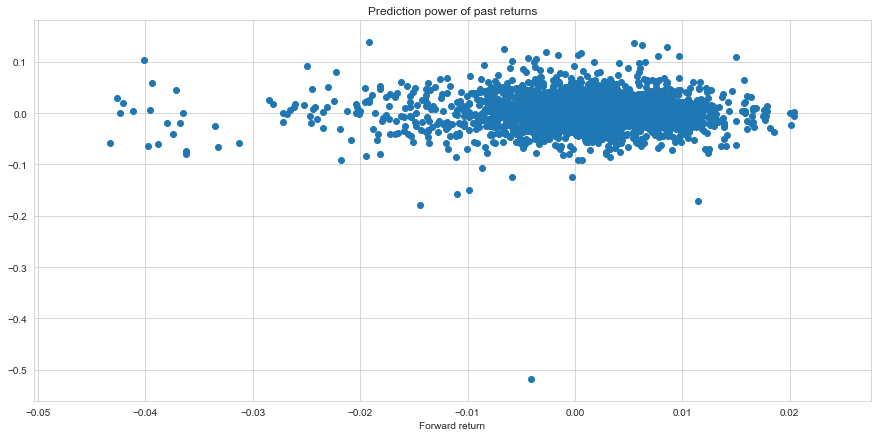

In [693]:
plt.figure(figsize=(15,7))
plt.scatter(X_train['Return_AAPL'].rolling(20).mean(), y_train)
plt.xlabel('Past returns')
plt.xlabel('Forward return')
plt.title('Prediction power of past returns')

## Checking missing value

Text(0.5, 1.0, 'NaN ratio')

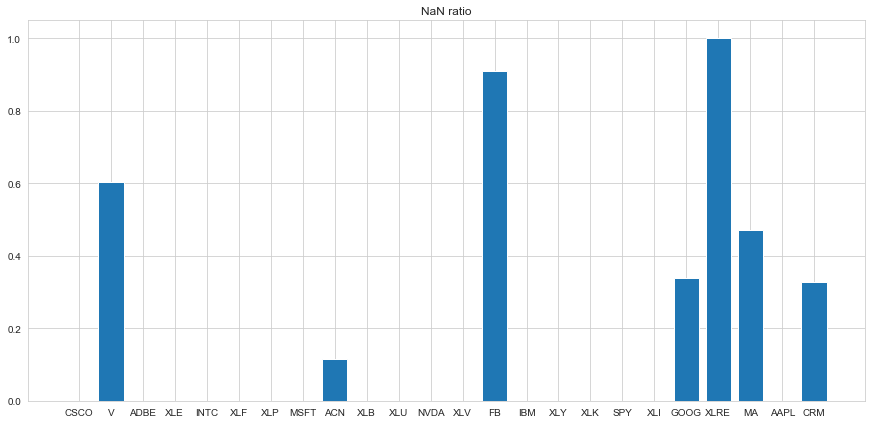

In [694]:
nan = X_train[['Return_'+ticker for ticker in tick_list]].isna().sum()/X_train.shape[0]

plt.figure(figsize=(15,7))
plt.bar(tick_list, nan.values)
plt.title('NaN ratio')

We can see that XLRE, FB, V, MA contains high percent of missing value. 

Therefore, we should remove XLRE and FB, and decrease the weight of using MA and V

Text(0.5, 1, 'Correlation matrix of returns')

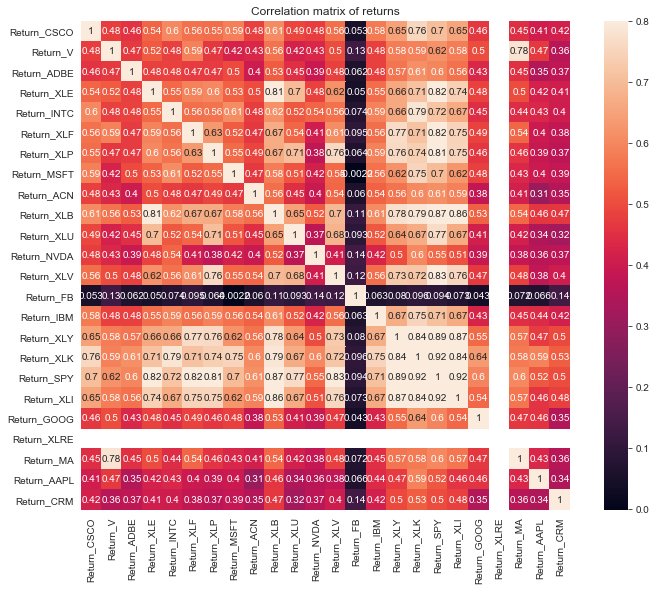

In [695]:
return_all = X_train[['Return_'+ticker for ticker in tick_list]].iloc[252*5:,]
cor_plot = return_all.corr()
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(cor_plot, vmax=.8, square=True, annot=True);
plt.title('Correlation matrix of returns')




Text(0.5, 1.0, 'Correlated tickers')

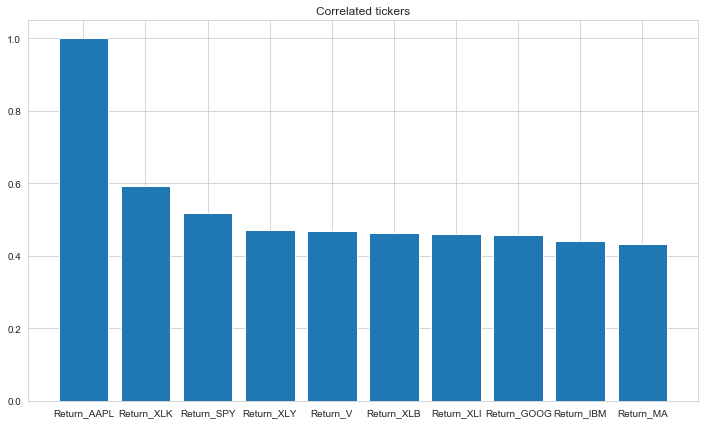

In [696]:
plt.subplots(figsize=(12, 7))
AAPL_ticker = cor_plot['Return_AAPL'].sort_values(ascending=False).iloc[:10]
plt.bar(AAPL_ticker.index, AAPL_ticker.values)
plt.title('Correlated tickers')

The stock highly correlated with AAPL are mostly ETFs, such as XLK, SPY, XLY, XLB, XLI.

Also, many stocks with technology background also highly correlated with AAPL. Therefore, we could use PCA to process the data

## Prepare the Data

### Data cleaning

Return_XLRE    1.000000
Return_FB      0.910552
Return_V       0.603332
Return_MA      0.470038
Return_GOOG    0.339959
Return_CRM     0.328267
Return_ACN     0.114002
Return_XLB     0.000292
Return_ADBE    0.000292
Return_XLE     0.000292
Return_INTC    0.000292
Return_XLF     0.000292
Return_XLP     0.000292
Return_MSFT    0.000292
Return_NVDA    0.000292
Return_XLU     0.000292
Return_AAPL    0.000292
Return_XLV     0.000292
Return_IBM     0.000292
Return_XLY     0.000292
Return_XLK     0.000292
Return_SPY     0.000292
Return_XLI     0.000292
Return_CSCO    0.000292
dtype: float64


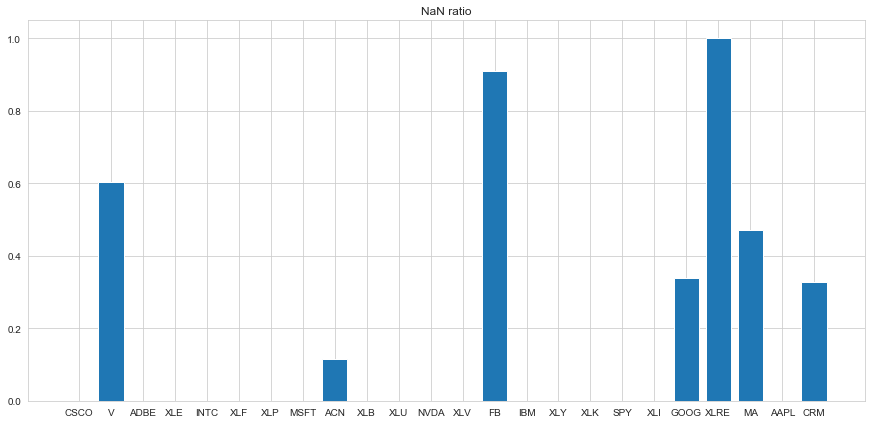

In [697]:
nan = X_train[['Return_'+ticker for ticker in tick_list]].isna().sum()/X_train.shape[0]

plt.figure(figsize=(15,7))
plt.bar(tick_list, nan.values)
plt.title('NaN ratio')
print(nan.sort_values(ascending=False))


In [698]:
# remove the columns with high percent of missing value
remove_threshold = 0.5

nan_ratio = X_train.isna().sum()/X_train.shape[0]

remove_columns = X_train.columns[nan_ratio>remove_threshold]
print('Remove columns due to sparsity: {}'.format(remove_columns))

X_train = X_train.drop(columns=remove_columns)
X_test = X_test.drop(columns=remove_columns)

Remove columns due to sparsity: Index(['Adj Close_V', 'Close_V', 'Div_V', 'Factor_V', 'High_V', 'Low_V',
       'Open_V', 'Volume_V', 'Return_V', 'Adj Return_V', 'Adj Close_FB',
       'Close_FB', 'Div_FB', 'Factor_FB', 'High_FB', 'Low_FB', 'Open_FB',
       'Volume_FB', 'Return_FB', 'Adj Return_FB', 'Adj Close_XLRE',
       'Close_XLRE', 'Div_XLRE', 'Factor_XLRE', 'High_XLRE', 'Low_XLRE',
       'Open_XLRE', 'Volume_XLRE', 'Return_XLRE', 'Adj Return_XLRE'],
      dtype='object')


In [699]:
high_tick = ["AAPL","XLK","SPY","XLY","XLB","XLI","GOOG","IBM","MA"]

In [700]:
def check_missing(df, remove_threshold=0.3):
    removed_row = list(df[df.isnull().mean(axis=1) > remove_threshold].index)
    keep = list(df[df.isnull().mean(axis=1) <= remove_threshold].index)

    print('Percent of Removed Rows: {}'.format(len(removed_row)/df.shape[0]))    
    return keep

keep = check_missing(X_train, remove_threshold=0.3)
X_train = X_train.loc[keep, :]
y_train = y_train.loc[keep]
print("X_train_all shape: ", X_train.shape)
print("y_train_all shape: ", y_train.shape)

Percent of Removed Rows: 0.00029231218941829873
X_train_all shape:  (3420, 210)
y_train_all shape:  (3420,)


### Imputation

In [701]:
# imputation mean values
mean_univariate_columns = [col for col in X_train.columns if col.split('_')[0] in ['Volume']]
zero_univariate_columns = [col for col in X_train.columns if col.split('_')[0] in ['Return', 'Div']]
one_univariate_columns = [col for col in X_train.columns if col.split('_')[0] in ['Factor']]
first_univariate_columns = [col for col in X_train.columns if col.split('_')[0].split(' ')[0] in ['Adj', 'Open', 'High', 'Low', 'Close']]



In [702]:
# imputation with mean
imputer_uni_mean = SimpleImputer(missing_values=np.nan, strategy='mean')
X_train[mean_univariate_columns] = pd.DataFrame(imputer_uni_mean.fit_transform(X_train[mean_univariate_columns]),columns = mean_univariate_columns).set_index(X_train[mean_univariate_columns].index)
X_test[mean_univariate_columns] = pd.DataFrame(imputer_uni_mean.transform(X_test[mean_univariate_columns]),columns = mean_univariate_columns).set_index(X_test[mean_univariate_columns].index)



In [703]:
# imputation with zero
imputer_uni_zero = SimpleImputer(missing_values=np.nan, strategy='constant', fill_value=0)
X_train[zero_univariate_columns] = pd.DataFrame(imputer_uni_zero.fit_transform(X_train[zero_univariate_columns]), columns = zero_univariate_columns).set_index(X_train[zero_univariate_columns].index)
X_test[zero_univariate_columns] = pd.DataFrame(imputer_uni_zero.transform(X_test[zero_univariate_columns]), columns = zero_univariate_columns).set_index(X_test[zero_univariate_columns].index)



In [704]:
# imputation with one
imputer_uni_one = SimpleImputer(missing_values=np.nan, strategy='constant', fill_value=1)
X_train[one_univariate_columns] = pd.DataFrame(imputer_uni_one.fit_transform(X_train[one_univariate_columns]),columns = one_univariate_columns).set_index(X_train[one_univariate_columns].index)
X_test[one_univariate_columns] = pd.DataFrame(imputer_uni_one.transform(X_test[one_univariate_columns]),columns = one_univariate_columns).set_index(X_test[one_univariate_columns].index)


In [705]:
# imputation with first value
X_train[first_univariate_columns] = X_train[first_univariate_columns].fillna(method='bfill')


In [706]:
X_train

,Adj Close_AAPL,Close_AAPL,Div_AAPL,Factor_AAPL,High_AAPL,Low_AAPL,Open_AAPL,Volume_AAPL,Return_AAPL,Adj Return_AAPL,...,Adj Close_CRM,Close_CRM,Div_CRM,Factor_CRM,High_CRM,Low_CRM,Open_CRM,Volume_CRM,Return_CRM,Adj Return_CRM
Dt,,,,,,,,,,,,,,,,,,,,,
2000-01-04,3.1852,102.50,0.0000,1.0,110.625,101.1880,108.2500,128094400.0,-0.084315,-0.084318,...,4.30,17.20,0.0,1.0,17.300,14.750,15.00,8.100767e+06,0.000000,-0.025581
2000-01-05,3.2318,104.00,0.0000,1.0,110.563,103.0000,103.7500,194580400.0,0.014634,0.014630,...,4.30,17.20,0.0,1.0,17.300,14.750,15.00,8.100767e+06,0.000000,-0.025581
2000-01-06,2.9521,95.00,0.0000,1.0,107.000,95.0000,106.1183,191993200.0,-0.086538,-0.086546,...,4.30,17.20,0.0,1.0,17.300,14.750,15.00,8.100767e+06,0.000000,-0.025581
2000-01-07,3.0920,99.50,0.0000,1.0,101.000,95.5000,96.5000,115183600.0,0.047368,0.047390,...,4.30,17.20,0.0,1.0,17.300,14.750,15.00,8.100767e+06,0.000000,-0.025581
2000-01-10,3.0376,97.75,0.0000,1.0,102.250,94.7500,102.0000,126266000.0,-0.017588,-0.017594,...,4.30,17.20,0.0,1.0,17.300,14.750,15.00,8.100767e+06,0.000000,-0.025581
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2013-08-02,58.7286,462.54,0.0000,1.0,462.850,456.6600,458.0100,68695900.0,0.012841,0.012833,...,45.52,45.52,0.0,1.0,45.600,44.930,44.97,3.494500e+06,0.008418,0.008418
2013-08-05,59.6059,469.45,0.0000,1.0,470.670,462.1167,464.6900,79713900.0,0.014939,0.014938,...,45.69,45.69,0.0,1.0,46.100,45.250,45.31,2.620900e+06,0.003735,0.003735
2013-08-06,59.0727,465.25,0.0000,1.0,471.890,462.1700,468.0200,83714400.0,-0.008947,-0.008945,...,45.42,45.42,0.0,1.0,45.645,44.900,45.38,2.750300e+06,-0.005909,-0.005909


In [707]:
assert X_train.isna().sum().sum() == 0
assert X_test.isna().sum().sum() == 0

print("Missing value in X_train is",X_train.isna().sum().sum())
print("Missing value in X_test is",X_test.isna().sum().sum())

Missing value in X_train is 0
Missing value in X_test is 0


Text(0.5, 1.0, 'Daily return')

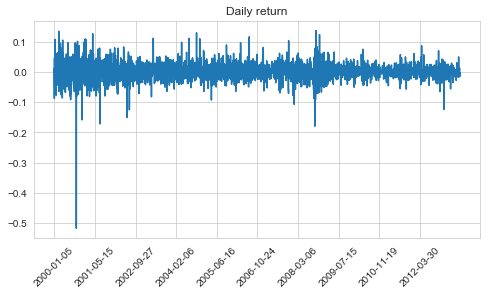

In [708]:
plt.figure(figsize=(8,4))
each = round(len(y_train.index)/10)
plt.xticks(list(range(1,len(y_train.index),each)), list(y_train.index[list(range(1,len(y_train.index),each))].values), rotation = 45)
plt.plot(y_train)
plt.title('Daily return')

There is an outlier, which is 2000-09-28

In [709]:
outlier_ret = y_train['2000-09-28']
outlier_ret

-0.5186766917293233

In [710]:
X_train = X_train.drop(['2000-09-28'], axis=0)
y_train = y_train.drop(['2000-09-28'])

X_train_all shape: (3419, 210)
y_train_all shape: (3419,)


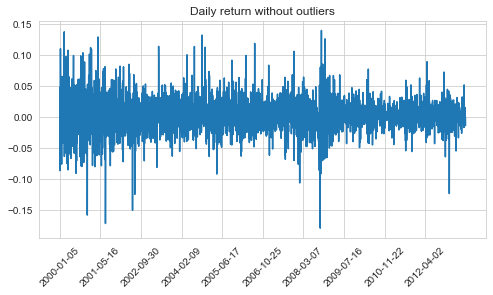

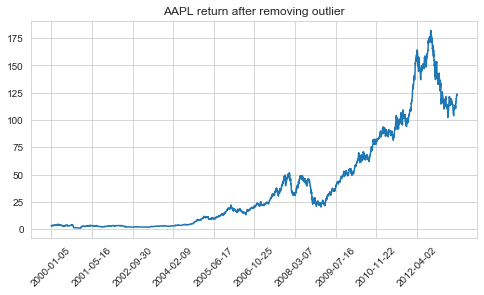

In [711]:
X_train.loc['2000-9-29':, ['Adj Close_AAPL']] = X_train.loc['2000-9-29':, ['Adj Close_AAPL']] / (1+outlier_ret) 
plt.figure(figsize=(8,4))
each = round(len(y_train.index)/10)
plt.xticks(list(range(1,len(y_train.index),each)), list(y_train.index[list(range(1,len(y_train.index),each))].values), rotation = 45)
plt.plot(y_train)
plt.title('Daily return without outliers')

plt.figure(figsize=(8,4))
each = round(len(y_train.index)/10)
plt.xticks(list(range(1,len(X_train.index),each)), list(X_train.index[list(range(1,len(X_train.index),each))].values), rotation = 45)
plt.plot(X_train['Adj Close_AAPL'])
plt.title('AAPL return after removing outlier')


print(f'X_train_all shape: {X_train.shape}')
print(f'y_train_all shape: {y_train.shape}')



In [712]:
train_len = X_train.shape[0]
X_all = pd.concat([X_train, X_test])
# AAPL features
AAPL_feature_columns = [col for col in X_all.columns if col.split('_')[1]=='AAPL']
print(AAPL_feature_columns)

['Adj Close_AAPL', 'Close_AAPL', 'Div_AAPL', 'Factor_AAPL', 'High_AAPL', 'Low_AAPL', 'Open_AAPL', 'Volume_AAPL', 'Return_AAPL', 'Adj Return_AAPL']


In [713]:
price_feature_columns = ['Adj Close_'+ticker for ticker in high_tick]
print(price_feature_columns)

['Adj Close_AAPL', 'Adj Close_XLK', 'Adj Close_SPY', 'Adj Close_XLY', 'Adj Close_XLB', 'Adj Close_XLI', 'Adj Close_GOOG', 'Adj Close_IBM', 'Adj Close_MA']


In [714]:
return_feature_columns = ['Return_'+ticker for ticker in high_tick]
print(return_feature_columns)

['Return_AAPL', 'Return_XLK', 'Return_SPY', 'Return_XLY', 'Return_XLB', 'Return_XLI', 'Return_GOOG', 'Return_IBM', 'Return_MA']


In [715]:
def RSI(price, window):
    change = price.diff(1).fillna(0)
    is_gain, is_loss = change > 0, change < 0
    gain, loss = change, -change
    gain[is_loss] = 0
    loss[is_gain] = 0
    rs = gain.ewm(span=window).mean().fillna(0) / loss.ewm(span=window).mean().fillna(0)
    rsi = (0.5 - (1 / (1 + rs))).fillna(0)
    return rsi

def OBV(price, volume, window):
    change = price.diff(1).fillna(0)
    return (np.sign(change) * volume).ewm(span=window).mean().fillna(0)

['RSI_7_AAPL', 'RSI_14_AAPL', 'RSI_28_AAPL', 'RSI_7_XLK', 'RSI_14_XLK', 'RSI_28_XLK', 'RSI_7_SPY', 'RSI_14_SPY', 'RSI_28_SPY', 'RSI_7_XLY', 'RSI_14_XLY', 'RSI_28_XLY', 'RSI_7_XLB', 'RSI_14_XLB', 'RSI_28_XLB', 'RSI_7_XLI', 'RSI_14_XLI', 'RSI_28_XLI', 'RSI_7_GOOG', 'RSI_14_GOOG', 'RSI_28_GOOG', 'RSI_7_IBM', 'RSI_14_IBM', 'RSI_28_IBM', 'RSI_7_MA', 'RSI_14_MA', 'RSI_28_MA', 'OBV_7_AAPL', 'OBV_14_AAPL', 'OBV_28_AAPL', 'OBV_7_XLK', 'OBV_14_XLK', 'OBV_28_XLK', 'OBV_7_SPY', 'OBV_14_SPY', 'OBV_28_SPY', 'OBV_7_XLY', 'OBV_14_XLY', 'OBV_28_XLY', 'OBV_7_XLB', 'OBV_14_XLB', 'OBV_28_XLB', 'OBV_7_XLI', 'OBV_14_XLI', 'OBV_28_XLI', 'OBV_7_GOOG', 'OBV_14_GOOG', 'OBV_28_GOOG', 'OBV_7_IBM', 'OBV_14_IBM', 'OBV_28_IBM', 'OBV_7_MA', 'OBV_14_MA', 'OBV_28_MA']


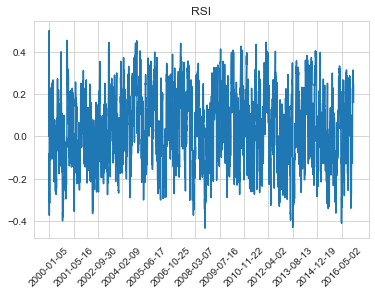

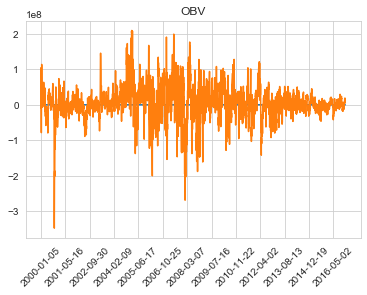

In [716]:
for ticker in high_tick:
    for window in [7, 14, 28]:
        X_all[f'RSI_{window}_{ticker}'] = RSI(X_all['Adj Close_'+ticker], window)
        X_all[f'OBV_{window}_{ticker}'] = OBV(X_all['Adj Close_'+ticker], X_all['Volume_'+ticker], window)
    
plt.figure()
each = round(len(y_train.index)/10)
plt.xticks(list(range(1,len(X_all.index),each)), list(X_all.index[list(range(1,len(X_all.index),each))].values), rotation = 45)
plt.plot(X_all['RSI_14_AAPL'])
plt.title('RSI')

plt.figure()
each = round(len(y_train.index)/10)
plt.xticks(list(range(1,len(X_all.index),each)), list(X_all.index[list(range(1,len(X_all.index),each))].values), rotation = 45)
plt.plot(X_all['RSI_14_AAPL'])
plt.plot(X_all['OBV_14_AAPL'])
plt.title('OBV')

trend_feature_columns = ([f'RSI_{window}_{ticker}' for ticker in high_tick for window in [7, 14, 28]] 
                        + [f'OBV_{window}_{ticker}' for ticker in high_tick for window in [7, 14, 28]])
print(trend_feature_columns)

In [717]:
for ticker in high_tick:
    X_all['log(Volume)_'+ticker] = np.log(X_all['Volume_'+ticker])

volume_feature_columns = ['log(Volume)_'+ticker for ticker in high_tick]
print(volume_feature_columns)

['log(Volume)_AAPL', 'log(Volume)_XLK', 'log(Volume)_SPY', 'log(Volume)_XLY', 'log(Volume)_XLB', 'log(Volume)_XLI', 'log(Volume)_GOOG', 'log(Volume)_IBM', 'log(Volume)_MA']


In [718]:
div_event = X_all['Div_AAPL']>0
split_event = X_all['Factor_AAPL']>1

X_all['is_div'] = X_all['Div_AAPL']>0
X_all['is_split'] = X_all['Factor_AAPL']>1

div_split_event_feature_columns = ['is_div', 'is_split']
print(div_split_event_feature_columns)

['is_div', 'is_split']


In [719]:
for ticker in high_tick:
    for window in [20, 60, 250]:
        X_all[f'Vol_{window}_{ticker}'] = X_all['Return_'+ticker].rolling(window).std().fillna(0)
        X_all[f'Range_{window}_{ticker}'] = ((X_all['High_'+ticker] - X_all['Low_'+ticker])/X_all['Close_'+ticker]).rolling(window).mean().fillna(0)

vol_feature_columns = ([f'Vol_{window}_{ticker}' for ticker in high_tick for window in [20, 60, 250]] 
                        + [f'Range_{window}_{ticker}' for ticker in high_tick for window in [20, 60, 250]])
print(vol_feature_columns)

['Vol_20_AAPL', 'Vol_60_AAPL', 'Vol_250_AAPL', 'Vol_20_XLK', 'Vol_60_XLK', 'Vol_250_XLK', 'Vol_20_SPY', 'Vol_60_SPY', 'Vol_250_SPY', 'Vol_20_XLY', 'Vol_60_XLY', 'Vol_250_XLY', 'Vol_20_XLB', 'Vol_60_XLB', 'Vol_250_XLB', 'Vol_20_XLI', 'Vol_60_XLI', 'Vol_250_XLI', 'Vol_20_GOOG', 'Vol_60_GOOG', 'Vol_250_GOOG', 'Vol_20_IBM', 'Vol_60_IBM', 'Vol_250_IBM', 'Vol_20_MA', 'Vol_60_MA', 'Vol_250_MA', 'Range_20_AAPL', 'Range_60_AAPL', 'Range_250_AAPL', 'Range_20_XLK', 'Range_60_XLK', 'Range_250_XLK', 'Range_20_SPY', 'Range_60_SPY', 'Range_250_SPY', 'Range_20_XLY', 'Range_60_XLY', 'Range_250_XLY', 'Range_20_XLB', 'Range_60_XLB', 'Range_250_XLB', 'Range_20_XLI', 'Range_60_XLI', 'Range_250_XLI', 'Range_20_GOOG', 'Range_60_GOOG', 'Range_250_GOOG', 'Range_20_IBM', 'Range_60_IBM', 'Range_250_IBM', 'Range_20_MA', 'Range_60_MA', 'Range_250_MA']


### PCA

5 has a cumulative explained variane of: 0.9384931991863276


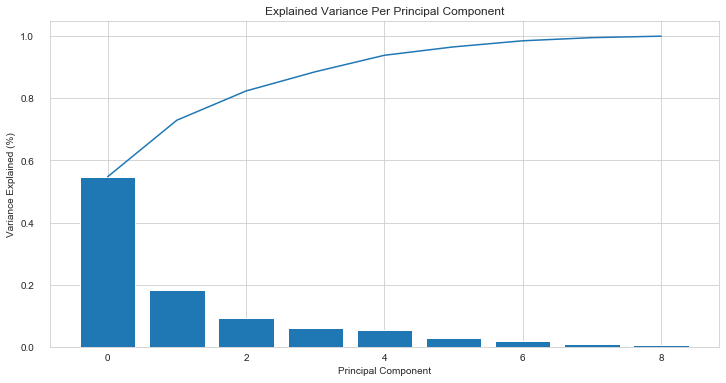

In [720]:
from sklearn.decomposition import PCA

def scree_plot(pca_estimator):

    num_components = len(pca_estimator.explained_variance_ratio_)
    ind = np.arange(num_components)
    vals = pca_estimator.explained_variance_ratio_
 
    plt.figure(figsize=(12, 6))
    ax = plt.subplot(111)
    cumvals = np.cumsum(vals)
    ax.bar(ind, vals)
    ax.plot(ind, cumvals)
    
    ax.xaxis.set_tick_params(width=0)
    ax.yaxis.set_tick_params(width=2, length=12)
 
    ax.set_xlabel("Principal Component")
    ax.set_ylabel("Variance Explained (%)")
    plt.title('Explained Variance Per Principal Component')
    
pca = PCA(n_components = .999)
X_train_return_pca = pca.fit_transform(X_train[return_feature_columns])
X_test_return_pca = pca.transform(X_test[return_feature_columns])

scree_plot(pca)

n_components = 5
print(f'{n_components} has a cumulative explained variane of: {sum(pca.explained_variance_ratio_[:n_components])}')

The plots above show that the explained variance plateaus a couple of times. The first and sharpest drop-off is around 1 component.

Then we will have a look at the components for each principle component.

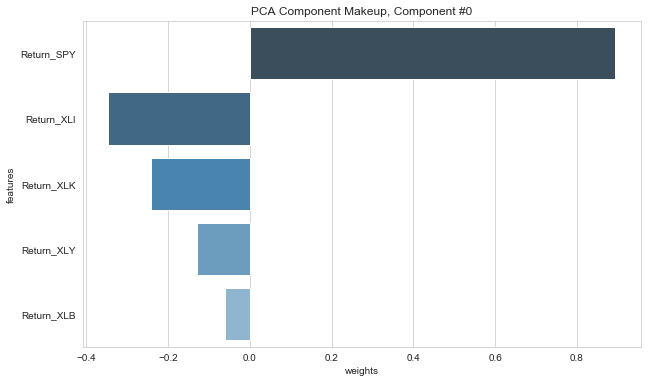

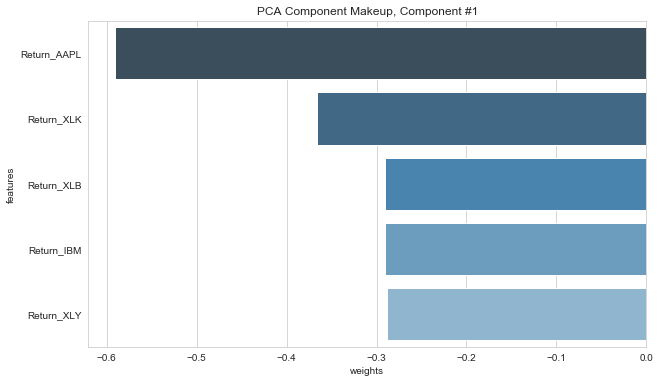

In [721]:
def display_component(v, features_list, component_num, n_weights=10):
    
    # get index of component (last row - component_num)
    row_idx = component_num - 1

    # get the list of weights from a row in v, dataframe
    v_1_row = v[row_idx]
    v_1 = np.squeeze(v_1_row)

    # match weights to features in counties_scaled dataframe, using list comporehension
    comps = pd.DataFrame(list(zip(v_1, features_list)), 
                         columns=['weights', 'features'])

    # we'll want to sort by the largest n_weights
    # weights can be neg/pos and we'll sort by magnitude
    comps['abs_weights']=comps['weights'].apply(lambda x: np.abs(x))
    sorted_weight_data = comps.sort_values('abs_weights', ascending=False).head(n_weights)

    # display using seaborn
    ax=plt.subplots(figsize=(10,6))
    ax=sns.barplot(data=sorted_weight_data, 
                   x="weights", 
                   y="features", 
                   palette="Blues_d")
    ax.set_title("PCA Component Makeup, Component #" + str(component_num))
    plt.show()

for num in range (0,2):
    display_component(pca.components_, return_feature_columns, component_num=num, n_weights=5)

Conclusion

We find that SPY, XLK, XLY explain most of the variance of the target.

The conclusion makes sense because we know from CAPM model that the large variance of AAPL returns should be explained by the market returns.

In [722]:
assert X_all.isna().sum().sum()==0
print(f'NaNs in X_all: {X_all.isna().sum().sum()}')

NaNs in X_all: 0


### Process Train test split

In [723]:
X_train_all = copy.deepcopy(X_train)
y_train_all = copy.deepcopy(y_train)

In [724]:
train_ratio = 0.9

num_train = int(X_train.shape[0] * train_ratio)

X_train_all, X_test = X_all.iloc[:train_len, :], X_all.iloc[train_len:, :]
X_train, X_valid = X_train_all.iloc[:num_train, :], X_train.iloc[num_train:, :]
y_train, y_valid = y_train_all.iloc[:num_train], y_train.iloc[num_train:]


print(f'X_train_all shape: {X_train_all.shape}')
print(f'X_train shape: {X_train.shape}')
print(f'X_valid shape: {X_valid.shape}')
print(f'X_test shape: {X_test.shape}')

print(f'y_train shape: {y_train.shape}')
print(f'y_valid shape: {y_valid.shape}')

X_train_all shape: (3419, 329)
X_train shape: (3077, 329)
X_valid shape: (342, 210)
X_test shape: (855, 329)
y_train shape: (3077,)
y_valid shape: (342,)


### Data Scaling

In [725]:
from sklearn.preprocessing import StandardScaler, RobustScaler

scaler = StandardScaler()
X_train_all_scale = pd.DataFrame(scaler.fit_transform(X_train_all), columns=X_train_all.columns)
X_test_scale = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)

### Model Training

In [726]:
import graphviz 
from sklearn import tree
from sklearn.pipeline import Pipeline

from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import cross_val_score

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras import layers
from tensorflow.keras.utils import plot_model
from tensorflow.keras import regularizers

from numpy.random import seed
seed(1)
tf.random.set_seed(2)


cross_validation_k = 5

In [727]:
def test_sklearn_model(X_train_all, X_test, y_train_all, y_test, test_pipelilne, name, cv=False):
    
    test_pipelilne.fit(X_train_all, y_train_all)
    y_train_predict = test_pipelilne.predict(X_train_all)

    r2_is = r2_score(y_train_all, y_train_predict)
    MSE_is = mean_squared_error(y_train_all, y_train_predict)    

    print("Model: {n:s}, in-sample R^2: {r:3.4%}, MSE: {m:3.4%}".format(n=name, r=r2_is, m=MSE_is))

    if cv:
        cross_val_scores = cross_val_score(test_pipelilne, X_train_all, y_train_all, scoring='neg_mean_squared_error', cv=cross_validation_k)
        print("Model: {n:s} average cross validation negative MSE={m:3.2%}".format(n=name, m=cross_val_scores.mean()))

    y_test_predict = test_pipelilne.predict(X_test)
    r2_oos = r2_score(y_test, y_test_predict)
    MSE_oos = mean_squared_error(y_test, y_test_predict)    
        
    print("Model: {n:s}, out-of-sample R^2: {r:3.4%}, MSE: {m:3.4%}".format(n=name, r=r2_oos, m=MSE_oos))
    
    return test_pipelilne

In [728]:
print('Test MSE: {m:3.4%}'.format(m=mean_squared_error(y_test, np.zeros(y_test.shape))))


Test MSE: 0.0230%


### Lasso Regression

1. Features: AAPL
Model: Linear regression, in-sample R^2: 0.1267%, MSE: 0.0756%
Model: Linear regression average cross validation negative MSE=-0.08%
Model: Linear regression, out-of-sample R^2: -9.9475%, MSE: 0.0252%
Model parameters:
Intercept: 0.00144
---------------------------------------------
2. Features: Return
Model: Linear regression, in-sample R^2: 0.8689%, MSE: 0.0750%
Model: Linear regression average cross validation negative MSE=-0.08%
Model: Linear regression, out-of-sample R^2: -0.5694%, MSE: 0.0231%
Model parameters:
Intercept: 0.00144


/Users/yipeizhang/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0912559081882327, tolerance: 0.00015251754786543248
  positive)
/Users/yipeizhang/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.42671499567985705, tolerance: 0.00023726521638331875
  positive)


---------------------------------------------
3. Features: Return + Volume
Model: Linear regression, in-sample R^2: 0.9985%, MSE: 0.0749%
Model: Linear regression average cross validation negative MSE=-0.08%
Model: Linear regression, out-of-sample R^2: -0.2198%, MSE: 0.0230%
Model parameters:
Intercept: 0.00144
---------------------------------------------
4. Features: Return + Volume + Price
Model: Linear regression, in-sample R^2: 1.2259%, MSE: 0.0747%
Model: Linear regression average cross validation negative MSE=-0.08%
Model: Linear regression, out-of-sample R^2: -13.5683%, MSE: 0.0260%
Model parameters:
Intercept: 0.00144
---------------------------------------------


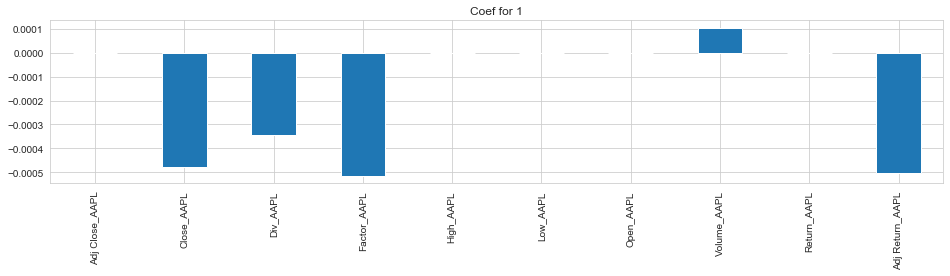

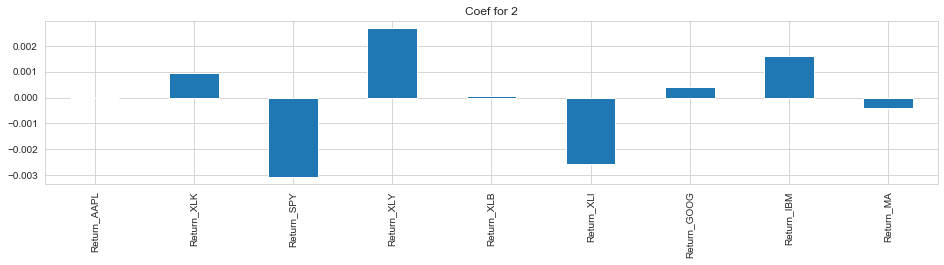

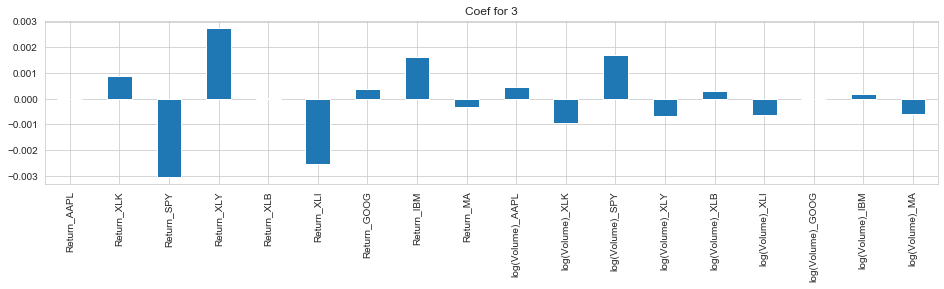

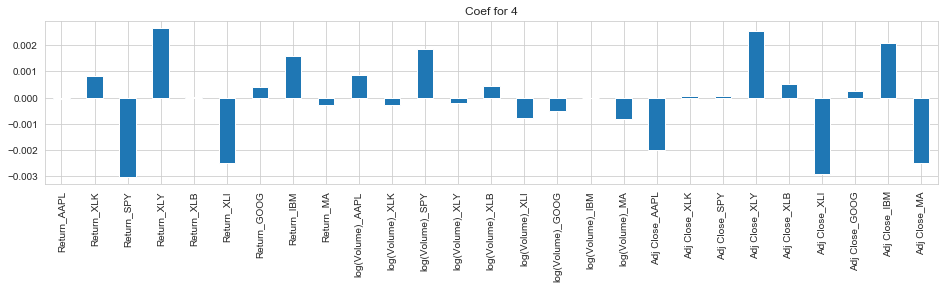

In [729]:

def lr_show_parameters(test_pipeline, title):
    print('Model parameters:')
    print(f"Intercept: {pipeline_lr['model'].intercept_:.5f}")
    plt.figure(figsize=(16,3))
    pd.Series(pipeline_lr['model'].coef_, index=used_features).plot(kind='bar')
    plt.title(title)
    print('---------------------------------------------')


name = 'Linear regression'

regressor = Lasso(alpha=0.00001)
pipeline_lr = Pipeline([
    ("scaler", scaler), 
    ("model", regressor)
])

print('1. Features: AAPL')
used_features = AAPL_feature_columns
pipeline_lr = test_sklearn_model(X_train_all[used_features], X_test[used_features], y_train_all, y_test, pipeline_lr, name, cv=True)
lr_show_parameters(pipeline_lr, 'Coef for 1')

print('2. Features: Return')
used_features = return_feature_columns
pipeline_lr = test_sklearn_model(X_train_all[used_features], X_test[used_features], y_train_all, y_test, pipeline_lr, name, cv=True)
lr_show_parameters(pipeline_lr, 'Coef for 2')

print('3. Features: Return + Volume')
used_features = return_feature_columns + volume_feature_columns
pipeline_lr = test_sklearn_model(X_train_all[used_features], X_test[used_features], y_train_all, y_test, pipeline_lr, name, cv=True)
lr_show_parameters(pipeline_lr, 'Coef for 3')

print('4. Features: Return + Volume + Price')
used_features = return_feature_columns + volume_feature_columns + price_feature_columns
pipeline_lr = test_sklearn_model(X_train_all[used_features], X_test[used_features], y_train_all, y_test, pipeline_lr, name, cv=True)
lr_show_parameters(pipeline_lr, 'Coef for 4')



In [730]:
pipeline_lr['model'].coef_


array([-5.51465133e-05,  8.25730890e-04, -3.00171042e-03,  2.64718935e-03,
        1.91305761e-05, -2.47563408e-03,  4.00607612e-04,  1.60655512e-03,
       -2.59665650e-04,  8.84895077e-04, -2.78065482e-04,  1.84992545e-03,
       -2.04304167e-04,  4.39222470e-04, -7.91164356e-04, -5.14646227e-04,
        0.00000000e+00, -8.03723242e-04, -1.97865864e-03,  7.72422458e-05,
        6.49136824e-05,  2.55509123e-03,  5.26514105e-04, -2.91725220e-03,
        2.65111717e-04,  2.09888394e-03, -2.49445352e-03])

### Decision tree

In [731]:
name = 'Decision tree regression'

print('1. Features: AAPL')

used_features = AAPL_feature_columns
regressor = DecisionTreeRegressor(random_state=0, max_depth=3, criterion='mse')
pipeline_dt = Pipeline([
    ("scaler", scaler), 
    ("model", regressor)
])
pipeline_dt = test_sklearn_model(X_train_all[used_features], X_test[used_features], y_train_all, y_test, pipeline_dt, name, cv=True)
dot_data = tree.export_graphviz(pipeline_dt['model'],
                                out_file=None,
                                feature_names=used_features,
                                class_names=True,
                                filled=True,
                                rounded=True
                               )


1. Features: AAPL
Model: Decision tree regression, in-sample R^2: 2.3599%, MSE: 0.0739%
Model: Decision tree regression average cross validation negative MSE=-0.08%
Model: Decision tree regression, out-of-sample R^2: -0.9086%, MSE: 0.0231%


In [732]:
print('2. Features: Return + Volume')

used_features = return_feature_columns
regressor = DecisionTreeRegressor(random_state=0, max_depth=3, criterion='mse')
pipeline_dt = Pipeline([
    ("scaler", scaler), 
    ("model", regressor)
])
pipeline_dt = test_sklearn_model(X_train_all[used_features], X_test[used_features], y_train_all, y_test, pipeline_dt, name, cv=True)

dot_data = tree.export_graphviz(pipeline_dt['model'],
                                out_file=None,
                                feature_names=used_features,
                                class_names=True,
                                filled=True,
                                rounded=True
                               )

2. Features: Return + Volume
Model: Decision tree regression, in-sample R^2: 3.5091%, MSE: 0.0730%
Model: Decision tree regression average cross validation negative MSE=-0.08%
Model: Decision tree regression, out-of-sample R^2: -4.5949%, MSE: 0.0240%


### Random Forrest

In [733]:
name = 'Random forrest regression'

regressor = RandomForestRegressor(max_depth=5, random_state=0)
pipeline_lr = Pipeline([
    ("scaler", scaler), 
    ("model", regressor)
])

print('1. Features: AAPL')
used_features = AAPL_feature_columns
pipeline_rf = test_sklearn_model(X_train_all[used_features], X_test[used_features], y_train_all, y_test, pipeline_lr, name, cv=True)

print('2. Features: Return')
used_features = return_feature_columns
pipeline_rf = test_sklearn_model(X_train_all[used_features], X_test[used_features], y_train_all, y_test, pipeline_lr, name, cv=True)

print('3. Features: Return + Volume')
used_features = return_feature_columns + volume_feature_columns
pipeline_rf = test_sklearn_model(X_train_all[used_features], X_test[used_features], y_train_all, y_test, pipeline_lr, name, cv=True)

print('4. Features: Return + Volume + Trend')
used_features = return_feature_columns + volume_feature_columns + trend_feature_columns
pipeline_rf = test_sklearn_model(X_train_all[used_features], X_test[used_features], y_train_all, y_test, pipeline_lr, name, cv=True)


1. Features: AAPL
Model: Random forrest regression, in-sample R^2: 8.3036%, MSE: 0.0694%
Model: Random forrest regression average cross validation negative MSE=-0.08%
Model: Random forrest regression, out-of-sample R^2: -0.9182%, MSE: 0.0231%
2. Features: Return
Model: Random forrest regression, in-sample R^2: 8.2045%, MSE: 0.0695%
Model: Random forrest regression average cross validation negative MSE=-0.08%
Model: Random forrest regression, out-of-sample R^2: -0.9328%, MSE: 0.0231%
3. Features: Return + Volume
Model: Random forrest regression, in-sample R^2: 9.3091%, MSE: 0.0686%
Model: Random forrest regression average cross validation negative MSE=-0.08%
Model: Random forrest regression, out-of-sample R^2: -0.4290%, MSE: 0.0230%
4. Features: Return + Volume + Trend
Model: Random forrest regression, in-sample R^2: 10.1587%, MSE: 0.0680%
Model: Random forrest regression average cross validation negative MSE=-0.08%
Model: Random forrest regression, out-of-sample R^2: 0.0501%, MSE: 0.02

### Simple RNN

In [734]:
def transform_dataset(train_set, test_set, y_train, y_test, n_input, n_output, verbose=True):
    all_data = np.vstack((train_set, test_set)).astype('float64')
    y_set = y_train.append(y_test).astype('float64')
    X = []
    y = []
    
    for i in range(all_data.shape[0] - n_input - n_output + 2):
        X_sample = all_data[i:i + n_input, :]
        y_sample = y_set[i + n_input - 1:i + n_input - 1 + n_output]
        X.append(X_sample)
        y.append(y_sample)   
    X = np.array(X)
    y = np.array(y)    
    train_all_X = X[:train_set.shape[0] - n_input + 1, :, :]
    train_all_y = y[:train_set.shape[0] - n_input + 1, :]
    test_X = X[train_set.shape[0] - n_input + 1:, :, :]
    test_y = y[train_set.shape[0] - n_input + 1:, :]
    
    num_train = int(train_all_X.shape[0] * train_ratio)
    
    train_X, valid_X = train_all_X[:num_train], train_all_X[num_train:]
    train_y, valid_y = train_all_y[:num_train], train_all_y[num_train:]
    
    if verbose:
        print(f'X_train_all_rnn shape: {train_all_X.shape}')
        print(f'X_train_rnn shape: {train_X.shape}')
        print(f'X_valid_rnn shape: {valid_X.shape}')
        print(f'X_test_rnn shape: {test_X.shape}')

        print(f'y_train_all_rnn shape: {train_all_y.shape}')
        print(f'y_train_rnn shape: {train_y.shape}')
        print(f'y_valid_rnn shape: {valid_y.shape}')
        print(f'y_test_rnn shape: {test_y.shape}')
    
    return train_all_X, train_all_y, test_X, test_y, train_X, train_y, valid_X, valid_y

In [735]:
def test_rnn_model(model_test, model_name_test, used_features, epochs=10): 
    loss='mean_squared_error'
    callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=100)    
    X_train_all_rnn, y_train_all_rnn, X_test_rnn, y_test_rnn, X_train_rnn, y_train_rnn, X_valid_rnn, y_valid_rnn = transform_dataset(X_train_all_scale[used_features], X_test_scale[used_features], y_train_all, y_test, 100, 1, verbose=False)
    
    optimizer = keras.optimizers.Adam(lr=0.005)
    model_test.compile(loss=loss, optimizer=optimizer, metrics='mean_squared_error')

    history_test = model_test.fit(X_train_rnn, y_train_rnn, epochs=epochs, validation_data=(X_valid_rnn, y_valid_rnn), verbose=0, callbacks=callback)

    score_test = model_test.evaluate(X_test_rnn, y_test_rnn, verbose=0)
    y_test_predict = model_test.predict(X_test_rnn)
    r_square = r2_score(y_test_rnn, y_test_predict)
    corr = np.corrcoef(y_test_rnn.T, y_test_predict.T)[0,1]
    
    num_parameters = model_test.count_params()

    print('{n:s}: Test Loss: {l:3.4%}, MSE: {m:3.4%}, R^2: {r:3.4%}, Corr: {c:3.4%}'.format(n=model_name_test, l=score_test[0], m=score_test[1], r=r_square, c=corr))
    print('Parameters number in model:', num_parameters)
    return model_test, y_test_predict

In [736]:
used_features = return_feature_columns

X_train_all_rnn, y_train_all_rnn, X_test_rnn, y_test_rnn, X_train_rnn, y_train_rnn, X_valid_rnn, y_valid_rnn = transform_dataset(X_train_all_scale[used_features], X_test_scale[used_features], y_train_all, y_test, 100, 1)


X_train_all_rnn shape: (3320, 100, 9)
X_train_rnn shape: (2988, 100, 9)
X_valid_rnn shape: (332, 100, 9)
X_test_rnn shape: (855, 100, 9)
y_train_all_rnn shape: (3320, 1)
y_train_rnn shape: (2988, 1)
y_valid_rnn shape: (332, 1)
y_test_rnn shape: (855, 1)


In [737]:
# Check if transformation to 3D array correctly
assert X_train_all_rnn[0,0,0] == X_train_all_scale[used_features].values[0,0]
assert X_train_all_rnn[-1,-1,0] == X_train_all_scale[used_features].values[-1,0]
assert y_train_all_rnn[-1] == y_train_all[-1]
assert y_test_rnn[0] == y_test[0]
assert y_test_rnn[-1] == y_test[-1]

#### Training

In [738]:
used_features = return_feature_columns

model_simple = Sequential()
model_simple.add(layers.SimpleRNN(1, input_shape=[None, len(used_features)]))

model_test_name = f'Simple RNN'
model_simple, _ = test_rnn_model(model_simple, model_test_name, used_features)

Simple RNN: Test Loss: 0.0258%, MSE: 0.0258%, R^2: -12.6150%, Corr: 1.8058%
Parameters number in model: 11


In [739]:
features_columns = [
    ('AAPL', AAPL_feature_columns),
    ('Return', return_feature_columns),
    ('Trend', trend_feature_columns),
]

for feature_name, used_features in features_columns:
    used_features = return_feature_columns

    model_simple = Sequential()
    model_simple.add(layers.SimpleRNN(1, input_shape=[None, len(used_features)]))
    model_test_name = f'Simple RNN {feature_name}:'
    model_simple, _  = test_rnn_model(model_simple, model_test_name, used_features)

Simple RNN AAPL:: Test Loss: 0.0259%, MSE: 0.0259%, R^2: -12.8462%, Corr: 1.7159%
Parameters number in model: 11
Simple RNN Return:: Test Loss: 0.0235%, MSE: 0.0235%, R^2: -2.7072%, Corr: 2.4859%
Parameters number in model: 11
Simple RNN Trend:: Test Loss: 0.0255%, MSE: 0.0255%, R^2: -11.0834%, Corr: 1.5628%
Parameters number in model: 11


### Deep RNN

In [740]:
used_features = return_feature_columns + trend_feature_columns + vol_feature_columns

for kernel_size in [10, 20, 50, 100]:
    model_deep = Sequential()
    model_deep.add(layers.SimpleRNN(kernel_size, input_shape=[None, len(used_features)], return_sequences=True))
    model_deep.add(layers.Dropout(0.2))
    model_deep.add(layers.SimpleRNN(kernel_size*2, return_sequences=True))
    model_deep.add(layers.Dropout(0.2))
    model_deep.add(layers.SimpleRNN(1))
    model_deep.add(layers.Dense(1))

    model_test_name = f'Deep RNN kernel_size={kernel_size}'
    model_deep, _  = test_rnn_model(model_deep, model_test_name, used_features)

Deep RNN kernel_size=10: Test Loss: 0.0239%, MSE: 0.0239%, R^2: -4.1053%, Corr: -0.5311%
Parameters number in model: 1924
Deep RNN kernel_size=20: Test Loss: 0.0230%, MSE: 0.0230%, R^2: -0.4837%, Corr: -2.8524%
Parameters number in model: 5244
Deep RNN kernel_size=50: Test Loss: 0.0229%, MSE: 0.0229%, R^2: 0.2981%, Corr: 6.3727%
Parameters number in model: 23604
Deep RNN kernel_size=100: Test Loss: 0.0229%, MSE: 0.0229%, R^2: 0.1177%, Corr: 5.1621%
Parameters number in model: 82204


### LSTM

In [741]:
used_features = return_feature_columns + volume_feature_columns + vol_feature_columns
kernel_size = 5

model_lstm = Sequential()
model_lstm.add(layers.LSTM(kernel_size, 
                           input_shape=[None, len(used_features)], 
                           kernel_initializer='glorot_uniform',
                           kernel_regularizer=regularizers.l2(0.0),
                           return_sequences=True))
model_lstm.add(layers.Dropout(0.5))
model_lstm.add(layers.LSTM(kernel_size*2, 
                           kernel_initializer='glorot_uniform',
                           kernel_regularizer=regularizers.l2(0.0),
                           return_sequences=True))
model_lstm.add(layers.Dropout(0.5))
model_lstm.add(layers.LSTM(kernel_size*2, 
                           kernel_initializer='glorot_uniform',
                           kernel_regularizer=regularizers.l2(0.0)))
model_lstm.add(layers.Dropout(0.5))
model_lstm.add(layers.Dense(1, kernel_initializer='glorot_uniform', kernel_regularizer=regularizers.l2(0.0)))

model_test_name = f'LSTM kernel_size={kernel_size}'
model_lstm, _ = test_rnn_model(model_lstm, model_test_name, used_features)

LSTM kernel_size=5: Test Loss: 0.0232%, MSE: 0.0232%, R^2: -1.3512%, Corr: 5.6622%
Parameters number in model: 3051


### Grid search

In [742]:
used_features = return_feature_columns + vol_feature_columns + volume_feature_columns

for kernel_size in [5, 10, 20, 50]:
    for dropout_rate in [0.2, 0.5, 0.7]:
        model_lstm = Sequential()
        model_lstm.add(layers.LSTM(kernel_size, 
                                   input_shape=[None, len(used_features)], 
                                   kernel_initializer='glorot_uniform',
                                   kernel_regularizer=regularizers.l2(0.0),
                                   return_sequences=True))
        model_lstm.add(layers.Dropout(dropout_rate))
        
        model_lstm.add(layers.LSTM(kernel_size*2, 
                                   kernel_initializer='glorot_uniform',
                                   kernel_regularizer=regularizers.l2(0.0),
                                   return_sequences=True))
        model_lstm.add(layers.Dropout(dropout_rate))
        
        model_lstm.add(layers.LSTM(kernel_size*2, 
                                   kernel_initializer='glorot_uniform',
                                   kernel_regularizer=regularizers.l2(0.0)))
        model_lstm.add(layers.Dropout(dropout_rate))
        
        model_lstm.add(layers.Dense(1, kernel_initializer='glorot_uniform', kernel_regularizer=regularizers.l2(0.0)))

        model_test_name = f'LSTM kernel_size={kernel_size}, dropout_rate={dropout_rate}'
        test_rnn_model(model_lstm, model_test_name, used_features)

LSTM kernel_size=5, dropout_rate=0.2: Test Loss: 0.0233%, MSE: 0.0233%, R^2: -1.6340%, Corr: -0.2473%
Parameters number in model: 3051
LSTM kernel_size=5, dropout_rate=0.5: Test Loss: 0.0230%, MSE: 0.0230%, R^2: -0.1702%, Corr: 0.4101%
Parameters number in model: 3051
LSTM kernel_size=5, dropout_rate=0.7: Test Loss: 0.0229%, MSE: 0.0229%, R^2: -0.0794%, Corr: 0.6552%
Parameters number in model: 3051
LSTM kernel_size=10, dropout_rate=0.2: Test Loss: 0.0270%, MSE: 0.0270%, R^2: -17.9884%, Corr: -2.7578%
Parameters number in model: 9101
LSTM kernel_size=10, dropout_rate=0.5: Test Loss: 0.0239%, MSE: 0.0239%, R^2: -4.2799%, Corr: 1.3265%
Parameters number in model: 9101
LSTM kernel_size=10, dropout_rate=0.7: Test Loss: 0.0231%, MSE: 0.0231%, R^2: -0.6836%, Corr: -0.4082%
Parameters number in model: 9101
LSTM kernel_size=20, dropout_rate=0.2: Test Loss: 0.0254%, MSE: 0.0254%, R^2: -10.8516%, Corr: 2.1569%
Parameters number in model: 30201
LSTM kernel_size=20, dropout_rate=0.5: Test Loss: 0.

I would use kernel size = 5, droupout rate=0.7

### Final Model

In [743]:
used_features = return_feature_columns + vol_feature_columns + volume_feature_columns

kernel_size = 5
dropout_rate = 0.7

model_lstm = Sequential()
model_lstm.add(layers.LSTM(kernel_size, 
                           input_shape=[None, len(used_features)], 
                           kernel_initializer='glorot_uniform',
                           kernel_regularizer=regularizers.l2(0.0),
                           return_sequences=True))
model_lstm.add(layers.Dropout(dropout_rate))
model_lstm.add(layers.LSTM(kernel_size*2, 
                           kernel_initializer='glorot_uniform',
                           kernel_regularizer=regularizers.l2(0.0),
                           return_sequences=True))
model_lstm.add(layers.Dropout(dropout_rate))
model_lstm.add(layers.LSTM(kernel_size*2, 
                           kernel_initializer='glorot_uniform',
                           kernel_regularizer=regularizers.l2(0.0)))
model_lstm.add(layers.Dropout(dropout_rate))
model_lstm.add(layers.Dense(1, kernel_initializer='glorot_uniform', kernel_regularizer=regularizers.l2(0.0)))

model_test_name = f'final_model'
model_lstm, _ = test_rnn_model(model_lstm, model_test_name, used_features, epochs=50)

final_model: Test Loss: 0.0229%, MSE: 0.0229%, R^2: 0.1348%, Corr: 5.0453%
Parameters number in model: 3051


In [744]:
import os
from tensorflow.keras.models import load_model

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid") 

import sklearn
from sklearn.impute import SimpleImputer



from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn import tree
from sklearn.pipeline import Pipeline

from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import cross_val_score

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras import layers
from tensorflow.keras.utils import plot_model
from tensorflow.keras import regularizers

from numpy.random import seed
seed(1)
tf.random.set_seed(2)

cross_validation_k = 5

modelName = "final_model"
model_path = os.path.join(".", modelName)

def saveModel(model, model_path): 
    try:
        os.makedirs(model_path)
    except OSError:
        print("Directory {dir:s} already exists, files will be over-written.".format(dir=model_path))
        
    # Save JSON config to disk
    json_config = model.to_json()
    with open(os.path.join(model_path, 'config.json'), 'w') as json_file:
        json_file.write(json_config)
    # Save weights to disk
    model.save_weights(os.path.join(model_path, 'weights.h5'))
    
    print("Model saved in directory {dir:s}; create an archive of this directory and submit with your assignment.".format(dir=model_path))
    
def loadModel(model_path):
    # Reload the model from the 2 files we saved
    with open(os.path.join(model_path, 'config.json')) as json_file:
        json_config = json_file.read()
    model = tf.keras.models.model_from_json(json_config)
    model.load_weights(os.path.join(model_path, 'weights.h5'))
    
    return model

def MyModel(test_dir, model_path):
    # YOU MAY NOT change model after this statement !
    model = loadModel(model_path)
    
    # It should run model to create an array of predictions; we initialize it to the empty array for convenience
    predictions = []
    
    # We need to match your array of predictions with the examples you are predicting
    # The array below (ids) should have a one-to-one correspondence and identify the example your are predicting
    # For Bankruptcy: the Id column
    # For Stock prediction: the date on which you are making a prediction
    ids = []
    
    # YOUR CODE GOES HERE
    trade_df, all_df = load_data(holdout_dir)
    X_train_all, X_test, y_train_all, y_test = train_test_split(all_df)
    X_train_all, X_test = imputation(X_train_all, X_test)
    useful_tickers = ["AAPL","XLK","SPY","XLY","XLB","XLI","GOOG","IBM","MA"]
    X_train_all,X_test = feature_engineering(X_train_all, X_test, useful_tickers)
    
    scaler = StandardScaler()
    X_train_all_scale = pd.DataFrame(scaler.fit_transform(X_train_all), columns=X_train_all.columns)
    X_test_scale = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)

    X_train_all_scale = pd.DataFrame(scaler.fit_transform(X_train_all), columns=X_train_all.columns)
    X_test_scale = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)
    
    return_feature_columns = ['Return_'+ticker for ticker in useful_tickers]
    vol_feature_columns = ([f'Vol_{window}_{ticker}' for ticker in useful_tickers for window in [20, 60, 250]] 
                                + [f'Range_{window}_{ticker}' for ticker in useful_tickers for window in [20, 60, 250]])
    volume_feature_columns = ['log(Volume)_'+ticker for ticker in useful_tickers]
    used_features = return_feature_columns + vol_feature_columns + volume_feature_columns

    model_test, y_test_predict = test_final_model(X_train_all_scale, X_test_scale, y_train_all, y_test, model, 'final model', used_features)
    prediction = y_test_predict
    ids = list(y_test.index)
    
    print(y_test_predict)
    return predictions, ids

def load_data(data_dir):
    
    all_tickers = []
    filenames = os.listdir(data_dir)
    for filename in filenames:
        all_tickers.append(filename.split('.')[0])
    
    trade_ticker = 'AAPL'
    
    trade_df = pd.read_csv(os.path.join(data_dir, f'{trade_ticker}.csv')).set_index('Dt')
    trade_df.index = pd.to_datetime(trade_df.index)
    trade_df['Return'] = trade_df['Close'].pct_change(periods=1)
    trade_df['Adj Return'] = trade_df['Adj Close'].pct_change(periods=1)
    

    all_df = trade_df.copy()
    
    
    # merge DataFrame
    for ticker in all_tickers:
        if ticker == trade_ticker:
            continue
        new_df = pd.read_csv(data_dir + ticker + '.csv').set_index("Dt")
        new_df.index = pd.to_datetime(new_df.index)
        new_df['Return'] = new_df['Close'].pct_change(periods=1)
        #all_df = all_df.join(new_df, how='left', rsuffix=f'_{ticker}') 
        new_df["Adj Return"] =new_df["Adj Close"].pct_change(1)
        all_df = all_df.join(new_df, how = "left", rsuffix = "_" + str(ticker))
           
    all_df.columns = [col+'_AAPL' for col in all_df.columns[:11]] + list(all_df.columns[11:])
    all_df['Forward_AAPL'] = all_df['Adj Close_AAPL'].pct_change(periods=1).shift(-1)
    return trade_df, all_df
def train_test_split(all_df):

    X, y = all_df.iloc[:,:-1].astype('float64'), all_df['Forward_AAPL'].astype('float64')

    X_train_all, X_test = X.iloc[: -200, :], X.iloc[-200:-1, :]
    y_train_all, y_test = y.iloc[: -200], y.iloc[-200:-1]
    return X_train_all, X_test, y_train_all, y_test

def imputation(X_train_all, X_test):
    # imputation mean values
    mean_univariate_columns = [col for col in X_train_all.columns if col.split('_')[0] in ['Volume']]
    zero_univariate_columns = [col for col in X_train_all.columns if col.split('_')[0] in ['Return', 'Div']]
    one_univariate_columns = [col for col in X_train_all.columns if col.split('_')[0] in ['Factor']]
    first_univariate_columns = [col for col in X_train_all.columns if col.split('_')[0].split(' ')[0] in ['Adj Close', 'Open', 'High', 'Low', 'Close']]


    # imputation with mean
    imputer_uni_mean = SimpleImputer(missing_values=np.nan, strategy='mean')
    X_train_all[mean_univariate_columns] = imputer_uni_mean.fit_transform(X_train_all[mean_univariate_columns])
    X_test[mean_univariate_columns] = imputer_uni_mean.transform(X_test[mean_univariate_columns])

    # imputation with zero
    imputer_uni_zero = SimpleImputer(missing_values=np.nan, strategy='constant', fill_value=0)
    X_train_all[zero_univariate_columns] = imputer_uni_zero.fit_transform(X_train_all[zero_univariate_columns])
    X_test[zero_univariate_columns] = imputer_uni_zero.transform(X_test[zero_univariate_columns])

    # imputation with one
    imputer_uni_one = SimpleImputer(missing_values=np.nan, strategy='constant', fill_value=1)
    X_train_all[one_univariate_columns] = imputer_uni_one.fit_transform(X_train_all[one_univariate_columns])
    X_test[one_univariate_columns] = imputer_uni_one.transform(X_test[one_univariate_columns])

    # imputation with first value
    X_train_all[first_univariate_columns] = X_train_all[first_univariate_columns].fillna(method='bfill')

    return X_train_all, X_test

def feature_engineering(X_train_all, X_test, useful_tickers):
    X_all = pd.concat([X_train_all, X_test])
    
    # technical
    for ticker in useful_tickers:
        for window in [7, 14, 28]:
            X_all[f'RSI_{window}_{ticker}'] = RSI(X_all['Adj Close_'+ticker], window)
            X_all[f'OBV_{window}_{ticker}'] = OBV(X_all['Adj Close_'+ticker], X_all['Volume_'+ticker], window)
    
    # volume
    for ticker in useful_tickers:
        X_all['log(Volume)_'+ticker] = np.log(X_all['Volume_'+ticker])
    
    
    # div/split
    div_event = X_all['Div_AAPL']>0
    split_event = X_all['Factor_AAPL']>1

    X_all['is_div'] = X_all['Div_AAPL']>0
    X_all['is_split'] = X_all['Factor_AAPL']>1
    
    # volatility
    for ticker in useful_tickers:
        for window in [20, 60, 250]:
            X_all[f'Vol_{window}_{ticker}'] = X_all['Return_'+ticker].rolling(window).std().fillna(0)
            X_all[f'Range_{window}_{ticker}'] = ((X_all['High_'+ticker] - X_all['Low_'+ticker])/X_all['Close_'+ticker]).rolling(window).mean().fillna(0)
    
    X_train_all, X_test = X_all.iloc[:-200, :], X_all.iloc[-200:, :]
    
    return X_train_all, X_test

def RSI(price, window):
    change = price.diff(1).fillna(0)
    is_gain, is_loss = change > 0, change < 0
    gain, loss = change, -change
    gain[is_loss] = 0
    loss[is_gain] = 0
    rs = gain.ewm(span=window).mean().fillna(0) / loss.ewm(span=window).mean().fillna(0)
    rsi = (0.5 - (1 / (1 + rs))).fillna(0)
    return rsi

def OBV(price, volume, window):
    change = price.diff(1).fillna(0)
    return (np.sign(change) * volume).ewm(span=window).mean().fillna(0)

def test_final_model(X_train_all_scale, X_test_scale, y_train_all, y_test, model_test, model_name_test, used_features, loss='mean_squared_error'): 
    callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=100)    
    X_train_all_rnn, y_train_all_rnn, X_test_rnn, y_test_rnn, X_train_rnn, y_train_rnn, X_valid_rnn, y_valid_rnn = transform_dataset(X_train_all_scale[used_features], X_test_scale[used_features], y_train_all, y_test, 100, 1, verbose=False)
    
    optimizer = keras.optimizers.Adam(lr=0.005)
    model_test.compile(loss=loss, optimizer=optimizer, metrics='mean_squared_error')


    score_test = model_test.evaluate(X_test_rnn, y_test_rnn, verbose=0)
    y_test_predict = model_test.predict(X_test_rnn)
    r_square = r2_score(y_test_rnn, y_test_predict)
    corr = np.corrcoef(y_test_rnn.T, y_test_predict.T)[0,1]
    
    num_parameters = model_test.count_params()

    print('{n:s}: Test Loss: {l:3.4%}, MSE: {m:3.4%}, R^2: {r:3.4%}, Corr: {c:3.4%}'.format(n=model_name_test, l=score_test[0], m=score_test[1], r=r_square, c=corr))
    print('Parameters number in model:', num_parameters)
    return model_test, y_test_predict

def transform_dataset(train_set, test_set, y_train, y_test, n_input, n_output, verbose=True):
    all_data = np.vstack((train_set, test_set)).astype('float64')
    y_set = y_train.append(y_test).astype('float64')
    X = []
    y = []
    
    for i in range(all_data.shape[0] - n_input - n_output + 2):
        X_sample = all_data[i:i + n_input, :]
        y_sample = y_set[i + n_input - 1:i + n_input - 1 + n_output]
        X.append(X_sample)
        y.append(y_sample)   
    X = np.array(X)
    y = np.array(y)    
    train_all_X = X[:train_set.shape[0] - n_input + 1, :, :]
    train_all_y = y[:train_set.shape[0] - n_input + 1, :]
    test_X = X[train_set.shape[0] - n_input + 1:, :, :]
    test_y = y[train_set.shape[0] - n_input + 1:, :]
    
    num_train = int(train_all_X.shape[0] * 0.9)
    
    train_X, valid_X = train_all_X[:num_train], train_all_X[num_train:]
    train_y, valid_y = train_all_y[:num_train], train_all_y[num_train:]
    
    if verbose:
        print(f'X_train_all_rnn shape: {train_all_X.shape}')
        print(f'X_train_rnn shape: {train_X.shape}')
        print(f'X_valid_rnn shape: {valid_X.shape}')
        print(f'X_test_rnn shape: {test_X.shape}')

        print(f'y_train_all_rnn shape: {train_all_y.shape}')
        print(f'y_train_rnn shape: {train_y.shape}')
        print(f'y_valid_rnn shape: {valid_y.shape}')
        print(f'y_test_rnn shape: {test_y.shape}')
    
    return train_all_X, train_all_y, test_X, test_y, train_X, train_y, valid_X, valid_y

# Assign to variable my_model the model that is your final model (the one  you will be evaluated on)
my_model = model_lstm

saveModel(my_model, model_path)

Directory ./final_model already exists, files will be over-written.
Model saved in directory ./final_model; create an archive of this directory and submit with your assignment.


In [746]:
holdout_dir = os.path.join(".", "Data", "holdout/")
predicts = MyModel(holdout_dir, model_path)

final model: Test Loss: 0.0135%, MSE: 0.0135%, R^2: -1.9709%, Corr: -9.5251%
Parameters number in model: 3051
[[9.5037068e-04]
 [9.5661380e-04]
 [9.1180031e-04]
 [6.9428346e-04]
 [4.1659654e-04]
 [1.6480929e-04]
 [1.7510564e-04]
 [2.4387107e-04]
 [4.4860493e-04]
 [8.1398472e-04]
 [1.1344305e-03]
 [1.3050594e-03]
 [1.2980780e-03]
 [1.2412587e-03]
 [1.1838038e-03]
 [1.4835986e-03]
 [1.6692167e-03]
 [1.7501276e-03]
 [1.9981484e-03]
 [2.4539151e-03]
 [2.3831320e-03]
 [2.4313454e-03]
 [2.1785665e-03]
 [1.9734283e-03]
 [1.9685074e-03]
 [1.7359196e-03]
 [1.6249027e-03]
 [1.5334247e-03]
 [1.6193867e-03]
 [1.6661806e-03]
 [1.5943178e-03]
 [1.3590676e-03]
 [1.1512742e-03]
 [1.0577904e-03]
 [9.7055751e-04]
 [7.8959658e-04]
 [5.9961784e-04]
 [4.0577247e-04]
 [3.5612797e-04]
 [4.7699921e-04]
 [5.6086486e-04]
 [4.5325712e-04]
 [3.6191160e-04]
 [2.2595143e-04]
 [1.4900789e-04]
 [4.3107779e-05]
 [6.4730295e-05]
 [7.5951335e-05]
 [8.0452301e-05]]


In [747]:
print("Done")


Done
